Initial portfolio value:10000
Final portfolio value: 22066.16015625
Final accumulative portfolio value: 2.206616015625
Maximum DrawDown: -0.047563245064179305
Sharpe ratio: 14.322368520568697
Initial portfolio value:10000
Final portfolio value: 13322.486328125
Final accumulative portfolio value: 1.3322486328125
Maximum DrawDown: -0.0014391539282820887
Sharpe ratio: 22.42316994502609


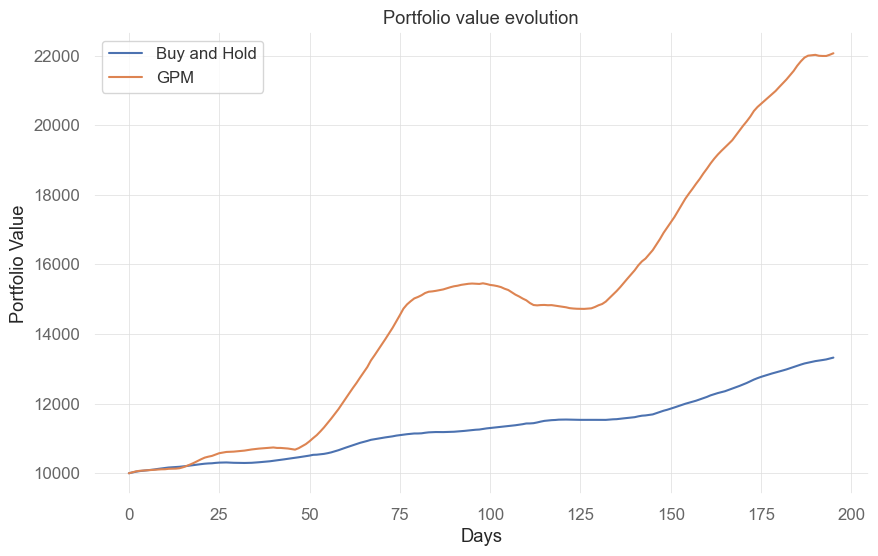

In [40]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.utils import k_hop_subgraph
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import GPM
import time

initial_amount=10000
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

nasdaq_temporal = pd.read_csv("Temporal_Relational_Stock_Ranking_FinRL/temporal_data/NASDAQ_temporal_data.csv")
nasdaq_edge_index = np.load("Temporal_Relational_Stock_Ranking_FinRL/relational_data/edge_indexes/NASDAQ_sector_industry_edge_index.npy")
nasdaq_edge_type = np.load("Temporal_Relational_Stock_Ranking_FinRL/relational_data/edge_types/NASDAQ_sector_industry_edge_type.npy")

list_of_stocks = nasdaq_temporal["tic"].unique().tolist()
tics_in_portfolio = ["AAPL", "CMCSA", "CSCO", "FB", "HBAN", "INTC", "MSFT", "MU", "NVDA", "QQQ", "XIV"]

portfolio_nodes = []
for tic in tics_in_portfolio:
    portfolio_nodes.append(list_of_stocks.index(tic))
portfolio_nodes

nodes_kept, new_edge_index, nodes_to_select, edge_mask = k_hop_subgraph(
    torch.LongTensor(portfolio_nodes),
    2,
    torch.from_numpy(nasdaq_edge_index),
    relabel_nodes=True,
)

# reduce temporal data
nodes_kept = nodes_kept.tolist()
nasdaq_temporal["tic_id"], _ = pd.factorize(nasdaq_temporal["tic"], sort=True)
nasdaq_temporal = nasdaq_temporal[nasdaq_temporal["tic_id"].isin(nodes_kept)]
nasdaq_temporal = nasdaq_temporal.drop(columns="tic_id")
nasdaq_temporal

# reduce edge type
new_edge_type = torch.from_numpy(nasdaq_edge_type)[edge_mask]
_, new_edge_type = torch.unique(new_edge_type, return_inverse=True)
new_edge_type

df_portfolio = nasdaq_temporal[["day", "tic", "close", "high", "low"]]
df_portfolio_train = df_portfolio[df_portfolio["day"] < 979]
df_portfolio_test = df_portfolio[df_portfolio["day"] >= 1000]
environment_train = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=initial_amount,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        time_column="day",
        normalize_df=None, # dataframe is already normalized
        tics_in_portfolio=tics_in_portfolio
    )
environment_test = PortfolioOptimizationEnv(
            df_portfolio_test,
            initial_amount=initial_amount,
            comission_fee_pct=0.0025,
            time_window=50,
            features=["close", "high", "low"],
            time_column="day",
            normalize_df=None, # dataframe is already normalized
            tics_in_portfolio=tics_in_portfolio
        )

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": GPM,
}
# here, we can set GPM's parameters
policy_kwargs = {
    "edge_index": new_edge_index,
    "edge_type": new_edge_type,
    "nodes_to_select": nodes_to_select
}
model = DRLAgent(environment_train).get_model("pg", device, model_kwargs, policy_kwargs)

GPM_results = {
    "test": {},
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = GPM(new_edge_index, new_edge_type, nodes_to_select, device=device)
policy.load_state_dict(torch.load("policy_GPM.pt"))

# testing
DRLAgent.DRL_validation(model, environment_test, policy=policy)
GPM_results["test"] = environment_test._asset_memory["final"]
fw = environment_test._final_weights
am = environment_test._asset_memory['final']


UBAH_results = {
    "test": {},
}

PORTFOLIO_SIZE = len(tics_in_portfolio)

# test period
terminated = False
environment_test.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_test.step(action)
UBAH_results["test"] = environment_test._asset_memory["final"]


fig, ax = plt.subplots()
ax.plot(UBAH_results["test"], label="Buy and Hold")
ax.plot(GPM_results["test"], label="GPM")

ax.set_xlabel("Days")
ax.set_ylabel("Portfolio Value")
ax.set_title("Portfolio value evolution")
ax.legend()

#fig.savefig('plots/result_GPM.jpg')


In [41]:
portfolio_distribution = [fw[i] * am[i] for i in range(len(am))]
portfolio_distribution

[array([10000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.], dtype=float32),
 array([2.2329507e+03, 9.0314359e-07, 6.9244971e-14, 2.7640890e-08,
        2.4462683e+02, 6.8327581e-13, 1.5734752e-01, 7.7540966e-07,
        5.8258086e+03, 1.7241515e+03, 2.4663458e-13, 8.9985202e-04],
       dtype=float32),
 array([2.2811758e+03, 8.6717154e-07, 6.5337980e-14, 2.7404226e-08,
        2.3875749e+02, 6.7583867e-13, 1.6265765e-01, 7.7701014e-07,
        5.8109863e+03, 1.7236711e+03, 2.3954170e-13, 8.3705870e-04],
       dtype=float32),
 array([2.3452439e+03, 8.3595307e-07, 6.2042798e-14, 2.7261747e-08,
        2.3405103e+02, 6.7239215e-13, 1.6935202e-01, 7.8368896e-07,
        5.7584502e+03, 1.7323503e+03, 2.3395616e-13, 7.8266696e-04],
       dtype=float32),
 array([2.4047102e+03, 8.0167217e-07, 5.8832381e-14, 2.6993030e-08,
        2.2841446e+02, 6.6621388e-13, 1.7636633e-01, 7.8822649e-07,
        5.7011865e+03, 1.7432819e+03, 2.2768820e-13

In [42]:
portfolio_names = ["Cash", "AAPL", "CMCSA", "CSCO", "FB", "HBAN", "INTC", "MSFT", "MU", "NVDA", "QQQ", "XIV"]

In [43]:
money_threshold = 1 #threshold of money of the stocks displayed
portfolio_evolution = []
for distrib in portfolio_distribution:
    portfolio_daily = dict()
    for j in range(len(distrib)):
        if distrib[j]>money_threshold:
            portfolio_daily[portfolio_names[j]] = distrib[j]
    portfolio_evolution.append(portfolio_daily)


In [44]:
portfolio_evolution

[{'Cash': 10000.0},
 {'Cash': 2232.9507, 'FB': 244.62683, 'MU': 5825.8086, 'NVDA': 1724.1515},
 {'Cash': 2281.1758, 'FB': 238.75749, 'MU': 5810.9863, 'NVDA': 1723.6711},
 {'Cash': 2345.244, 'FB': 234.05103, 'MU': 5758.45, 'NVDA': 1732.3503},
 {'Cash': 2404.7102, 'FB': 228.41446, 'MU': 5701.1865, 'NVDA': 1743.2819},
 {'Cash': 2459.6833, 'FB': 222.21666, 'MU': 5646.4497, 'NVDA': 1756.3394},
 {'Cash': 2511.9294, 'FB': 215.7266, 'MU': 5590.8306, 'NVDA': 1773.9961},
 {'Cash': 2562.0186, 'FB': 208.97166, 'MU': 5530.96, 'NVDA': 1796.5387},
 {'Cash': 2609.2095, 'FB': 201.9864, 'MU': 5475.7974, 'NVDA': 1822.813},
 {'Cash': 2655.8477, 'FB': 194.87556, 'MU': 5411.8643, 'NVDA': 1850.7463},
 {'Cash': 2697.772, 'FB': 187.84402, 'MU': 5345.92, 'NVDA': 1883.6233},
 {'Cash': 1.5108544, 'FB': 247.51277, 'MU': 7191.314, 'NVDA': 2686.7888},
 {'Cash': 1.5164346, 'FB': 237.22943, 'MU': 7145.5103, 'NVDA': 2744.4277},
 {'Cash': 1.5256118, 'FB': 228.0785, 'MU': 7087.1353, 'NVDA': 2816.0662},
 {'Cash': 1.533390

In [34]:
portfolio_evolution = [dict(zip(portfolio_names, port_dist)) for port_dist in portfolio_distribution]

In [37]:
portfolio_evolution[-1]

{'Cash': 956.24207,
 'AAPL': 5.425794e-06,
 'CMCSA': 3.6784868e-09,
 'CSCO': 9.2922e-06,
 'FB': 6356.4917,
 'HBAN': 3.255631e-09,
 'INTC': 569.9478,
 'MSFT': 1.7672915e-05,
 'MU': 1765.7041,
 'NVDA': 381.50974,
 'QQQ': 1.9855386e-11,
 'XIV': 1.0763392e-05}